In [1]:
%load_ext autoreload
%autoreload 2

import gymnasium as gym
from gymnasium.envs.registration import register
import toy_env as te
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# register(
#      id="ToyEnv-v0",
#      entry_point="gym_examples.envs:GridWorldEnv",
#      max_episode_steps=300,
# )

# Notes

The policy can be regard not as the policy chosen when we have i links in the memory but when we want to generate s-i links ahead

the interpolation generates several actions that give a 'sweep' over all bins

is the general distribution approximately exponential

need rigor content in the paper

impossible to interpolate without knowledge between sending 1/2 link actions

In [2]:


p1, p2 = 0.2, 0.5
lam = 0.2
protocols = [[p1,p2],[1-lam*p1,1-lam*p2]]
num_qubits = 20
threshold = 0.9
decay_rate = 0.005
env = te.ToyEnv(protocols, num_qubits ,threshold, decay_rate)

the total bin size is:
17.0
the bins are:
[17.0, 0.0]


### baseline

In [79]:
# random choice
depth_random = []
shots = 2000
for i in tqdm(range(shots)):
    obs = []
    observation, info = env.reset()
    obs.append(observation)
    while True:
        action = np.random.choice([0,1])
        observation, reward, terminated, truncated, info = env.step(action)
        obs.append(observation)
        # print(observation)
        if terminated:
            break
    depth_random.append(len(obs))

m_depth_random = np.mean(depth_random)
std_depth_random = np.std(depth_random)
plt.hist(depth_random,bins=20)
print(m_depth_random)
print(std_depth_random)
print(depth_random)

  0%|          | 0/2000 [01:14<?, ?it/s]


KeyboardInterrupt: 

In [77]:
# fixed action
protocols_fixed = [[0.2],[0.96]]
env_fixed = te.ToyEnv(protocols_fixed, num_qubits ,threshold, decay_rate)

depth_fixed = []
shots = 200000
for i in tqdm(range(shots)):
    obs = []
    observation, info = env_fixed.reset()
    obs.append(observation)
    while True:
        observation, reward, terminated, truncated, info = env_fixed.step(0)
        obs.append(observation)
        # print(observation)
        if terminated:
            break
    depth_fixed.append(len(obs))

m_depth_fixed = np.mean(depth_fixed)
std_depth_fixed = np.std(depth_fixed)
plt.hist(depth_fixed,bins=100)
print(m_depth_fixed)
print(std_depth_fixed)
print(depth_fixed)

the total bin size is:
8.0
the bins are:
[8.0]


  0%|          | 0/200000 [00:04<?, ?it/s]


KeyboardInterrupt: 

### Heuristics

In [3]:
import p_env as penv

p1, p2 = 0.1, 0.5
lam = 0.2
protocols = [[p1,p2],[1-lam*p1,1-lam*p2]]
num_qubits = 12
threshold = 0.9
decay_rate = 0.01
env_p = penv.PEnv(protocols, num_qubits,threshold,decay_rate)



top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 12
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


In [67]:
import aksel_env as aenv
env_a = aenv.AEnv(protocols,num_qubits,threshold,decay_rate)

depth_heuristic = []
for i in range(2000):
    depth = env_a.run()
    depth_heuristic.append(depth)

print(np.mean(depth_heuristic))
print(np.std(depth_heuristic))

top bin: 19
top native bin: 14
lowest native bin: 0
[0.4999999999999999, 0.48586484633112625, 0.4709304823852821, 0.45515172032215223, 0.4384808173531547, 0.4208673312830945, 0.4022579678840549, 0.3825964196397138, 0.36182319537216595, 0.33987544023573896, 0.3166867455331512, 0.29218694777855664, 0.266301916399492, 0.2389533294353608, 0.21005843655377116, -1, -1, -1, -1, -1]
454.231
434.08071558063943


In [73]:
import batch_env as benv
env_b = benv.BatchEnv(protocols,num_qubits/2,threshold,decay_rate)

depth_heuristic = []
for i in range(2000):
    depth = env_b.run()
    depth_heuristic.append(depth)

print(np.mean(depth_heuristic))
print(np.std(depth_heuristic))

top bin: 19
top native bin: 14
lowest native bin: 0
[0.4999999999999999, 0.48586484633112625, 0.4709304823852821, 0.45515172032215223, 0.4384808173531547, 0.4208673312830945, 0.4022579678840549, 0.3825964196397138, 0.36182319537216595, 0.33987544023573896, 0.3166867455331512, 0.29218694777855664, 0.266301916399492, 0.2389533294353608, 0.21005843655377116, -1, -1, -1, -1, -1]
319.491
309.8222230876927


In [4]:
def policy_maker_compare(env_p, alpha = 1):
    ahead = [0]
    actions = env_p.actions
    policy = []
    count = 0
    
    for i in range(env_p.num_qubits):
        p1, p2, action1, action2 = 0,0,0,0
        #non purification
        lb = env_p.bin_size_min if env_p.bin_size_min>=0 else 0
        if i==0:
            p1 = actions[0][lb]
            action1 = (0,lb)
        else:
            n = np.floor(ahead[i-1]).astype(int)
            if n<lb:
                n = lb
            elif n>env_p.bin_size:
                n = env_p.bin_size
            p1 = actions[0][n]
            action1 = (0,n)
        #purification
            p2 = actions[1][-1]
            action2 = (1,env_p.top_bin)
        if p1*2>=p2:
            policy.append(action1)
            prev_ahead = ahead[i-1]
        else:
            policy.append(action1)
            prev_ahead = ahead[i-1]
        ahead.append(prev_ahead + alpha/actions[policy[i][0]][policy[i][1]])
    return policy[::-1]

def policy_maker(env_p, alpha = 1):
    ahead = [0]
    actions = env_p.actions
    policy = []
    count = 0
    
    for i in range(env_p.num_qubits):
        p1, p2, action1, action2 = 0,0,0,0
        #non purification
        lb = env_p.bin_size_min if env_p.bin_size_min>=0 else 0
        if i==0:
            p1 = actions[0][lb]
            action1 = (0,lb)
        else:
            n = np.floor(ahead[i-1]).astype(int)
            if n<lb:
                n = lb
            elif n>env_p.bin_size:
                n = env_p.bin_size
            p1 = actions[0][n]
            action1 = (0,n)
        #purification
            p2 = actions[1][-1]
            action2 = (1,env_p.top_bin)
        if i==0 or 1/p1+ahead[i-1]<=1/p2 + ahead[i]:
            policy.append(action1)
            prev_ahead = ahead[i-1]
        else:
            policy.append(action2)
            prev_ahead = ahead[i]
        ahead.append(prev_ahead + alpha/actions[policy[i][0]][policy[i][1]])
    return policy[::-1]

def policy_maker_draft(env_p, alpha = 1):
    ahead = [0]
    actions = env_p.actions
    policy = []
    count = 0
    
    for i in range(env_p.num_qubits):
        p1, p2, action1, action2 = 0,0,0,0
        #non purification
        lb = env_p.bin_size_min if env_p.bin_size_min>=0 else 0
        if i==0:
            p1 = actions[0][lb]
            action1 = (0,lb)
        else:
            n = np.floor(ahead[i-1]).astype(int)
            if n<lb:
                n = lb
            elif n>env_p.bin_size:
                n = env_p.bin_size
            p1 = actions[0][n]
            action1 = (0,n)
        #purification
            p2 = actions[1][-1]
            action2 = (1,env_p.top_bin)
        if 2*p1>=p2:
            policy.append(action1)
            prev_ahead = ahead[i-1]
        else:
            policy.append(action2)
            prev_ahead = ahead[i]
        ahead.append(prev_ahead + alpha/actions[policy[i][0]][policy[i][1]])
    return policy[::-1]



print(policy_maker(env_p))
print(policy_maker_compare(env_p))

[(1, 14), (1, 14), (1, 14), (1, 14), (0, 6), (1, 14), (0, 4), (1, 14), (0, 1), (0, 1), (0, 0), (0, 0)]
[(0, 11), (0, 11), (0, 10), (0, 10), (0, 6), (0, 6), (0, 4), (0, 4), (0, 1), (0, 1), (0, 0), (0, 0)]


In [5]:
def batch_heuristic(shots, env, policy, progress = True, t_ahead=None):
    depth_heuristic = []
    if progress == True:
        bar = tqdm(range(shots))
    else:
        bar = range(shots)
    for i in bar:
        if t_ahead == None:
            depth = env.run(policy)
        else:
            depth = env.run(policy, t_ahead)
        depth_heuristic.append(depth)
    return depth_heuristic

policy = policy_maker(env_p,1.12)
print(policy)
test = batch_heuristic(1,env_p,policy)
print('can run one batch')
depth_heuristic = batch_heuristic(2000,env_p,policy)
print(np.mean(depth_heuristic))
print(np.std(depth_heuristic))


[(1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (1, 14), (0, 4), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


can run one batch


100%|██████████| 2000/2000 [00:00<00:00, 2906.58it/s]

112.612
112.86588703412559


In [29]:
h_mean_cmp = []
h_std_cmp = []
space = np.linspace(1,1.7,100)
for alpha in space:
    policy = policy_maker_compare(env_p, alpha)
    print(policy,alpha)
    depth_heuristic = batch_heuristic(2000,env_p,policy,False)
    h_mean_cmp.append(np.mean(depth_heuristic))
    h_std_cmp.append(np.std(depth_heuristic))

print(np.amin(h_mean_cmp))
plt.plot(space, h_mean_cmp)
plt.xlabel('alpha')
plt.ylabel('expected time')
plt.show()
plt.plot(space, h_std_cmp)
plt.show()

[(0, 8), (0, 8), (0, 8), (0, 8), (0, 6), (0, 6), (0, 4), (0, 4), (0, 1), (0, 1), (0, 0), (0, 0)] 1.0
[(0, 8), (0, 8), (0, 8), (0, 8), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)] 1.007070707070707
[(0, 8), (0, 8), (0, 8), (0, 8), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)] 1.0141414141414142
[(0, 8), (0, 8), (0, 8), (0, 8), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)] 1.0212121212121212
[(0, 8), (0, 8), (0, 8), (0, 8), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)] 1.0282828282828282


KeyboardInterrupt: 

In [30]:
h_mean = []
h_std = []
space = np.linspace(1,1.7,100)
for alpha in space:
    policy = policy_maker(env_p, alpha)
    print(policy,alpha)
    depth_heuristic = batch_heuristic(2000,env_p,policy,False)
    h_mean.append(np.mean(depth_heuristic))
    h_std.append(np.std(depth_heuristic))

print(np.amin(h_mean))
plt.plot(space, h_mean)
plt.xlabel('alpha')
plt.ylabel('expected time')
plt.show()
plt.plot(space, h_std)
plt.show()



[(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 0)] 1.0
[(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 0)] 1.007070707070707
[(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 0)] 1.0141414141414142
[(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 0)] 1.0212121212121212
[(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 0)] 1.0282828282828282


KeyboardInterrupt: 

In [7]:
import sys
def optimize_nop(shots, env, alpha_space):
    param = -1
    best_depth = sys.maxsize
    depth_data = []
    policy_data = []
    for alpha in tqdm(alpha_space):
        policy = policy_maker_compare(env, alpha)
        depth_heuristic = batch_heuristic(shots,env,policy,False) 
        depth = np.mean(depth_heuristic)
        if  best_depth>depth:
            best_depth = depth
            depth_data = depth_heuristic
            policy_data = policy
            param = alpha
    return depth_data, param, policy_data

def optimize_p(shots, env, alpha_space):
    param = -1
    best_depth = sys.maxsize
    depth_data = []
    policy_data = []
    for alpha in tqdm(alpha_space):
        policy = policy_maker(env, alpha)
        depth_heuristic = batch_heuristic(shots,env,policy,False) 

        depth = np.mean(depth_heuristic)
        if  best_depth>depth:
            best_depth = depth
            depth_data = depth_heuristic
            policy_data = policy
            param = alpha
    return depth_data, param, policy_data

def optimize_palt(shots, env, alpha_space):
    param = -1
    best_depth = sys.maxsize
    depth_data = []
    policy_data = []
    for alpha in tqdm(alpha_space):
        policy = policy_maker_draft(env, alpha)
        depth_heuristic = batch_heuristic(shots,env,policy,False) 

        depth = np.mean(depth_heuristic)
        if  best_depth>depth:
            best_depth = depth
            depth_data = depth_heuristic
            policy_data = policy
            param = alpha
    return depth_data, param, policy_data



top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 6
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


1.5358974358974358 [(0, 6), (1, 14), (0, 3), (1, 14), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 7
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


1.6589743589743589 [(1, 14), (0, 7), (1, 14), (0, 3), (1, 14), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 8
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


1.5974358974358975 [(1, 14), (1, 14), (0, 7), (1, 14), (0, 3), (1, 14), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 9
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:07<00:00,  5.65it/s]


1.5564102564102564 [(1, 14), (1, 14), (1, 14), (0, 6), (1, 14), (0, 3), (1, 14), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 10
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:11<00:00,  3.59it/s]


1.2282051282051283 [(1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 11
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


1.1871794871794872 [(1, 14), (1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 12
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


1.2076923076923078 [(1, 14), (1, 14), (1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 13
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


1.1666666666666667 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 14
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [02:37<00:00,  3.94s/it]


1.1256410256410256 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (1, 14), (0, 4), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 15
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [07:33<00:00, 11.34s/it]


1.1871794871794872 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 16
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 40/40 [34:53<00:00, 52.33s/it] 


1.1666666666666667 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 8), (1, 14), (0, 5), (1, 14), (0, 2), (0, 2), (0, 0), (0, 0)]


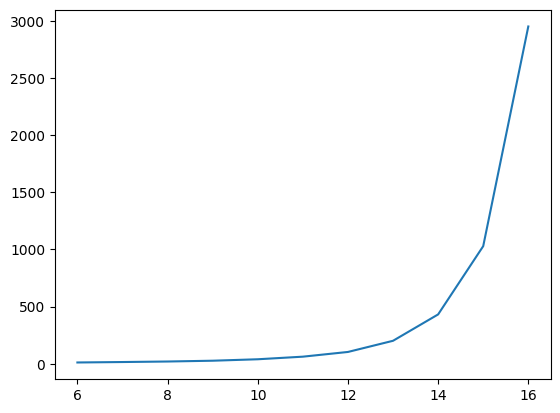

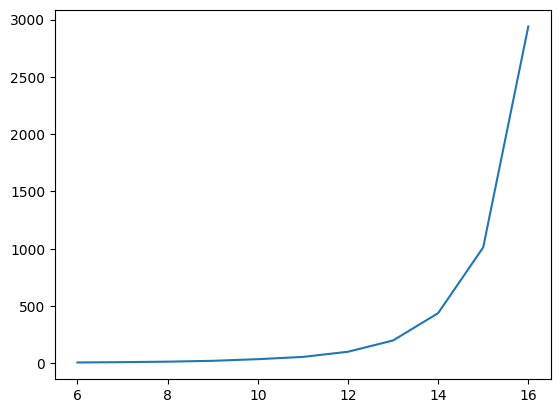

top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 6
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:02<00:00, 14.58it/s]


1.7 [(0, 7), (0, 7), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 7
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:04<00:00,  7.14it/s]


1.2862068965517242 [(0, 9), (0, 5), (0, 5), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 8
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


1.3413793103448275 [(0, 9), (0, 9), (0, 5), (0, 5), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 9
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


1.2310344827586206 [(0, 11), (0, 8), (0, 8), (0, 5), (0, 5), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 10
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


1.203448275862069 [(0, 11), (0, 11), (0, 8), (0, 8), (0, 5), (0, 5), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 11
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:24<00:00,  1.20it/s]


1.0103448275862068 [(0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 12
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


1.0103448275862068 [(0, 11), (0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 13
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


1.0103448275862068 [(0, 11), (0, 11), (0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 14
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [01:31<00:00,  3.03s/it]


1.0103448275862068 [(0, 11), (0, 11), (0, 11), (0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 15
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [11:04<00:00, 22.14s/it]


1.0103448275862068 [(0, 11), (0, 11), (0, 11), (0, 11), (0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 16
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [10:44<00:00, 21.49s/it]

1.0103448275862068 [(0, 11), (0, 11), (0, 11), (0, 11), (0, 11), (0, 11), (0, 10), (0, 10), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]


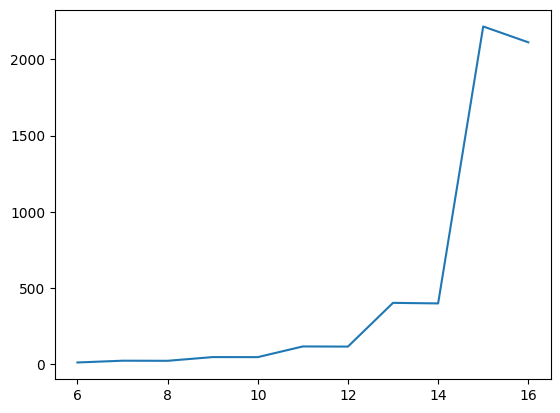

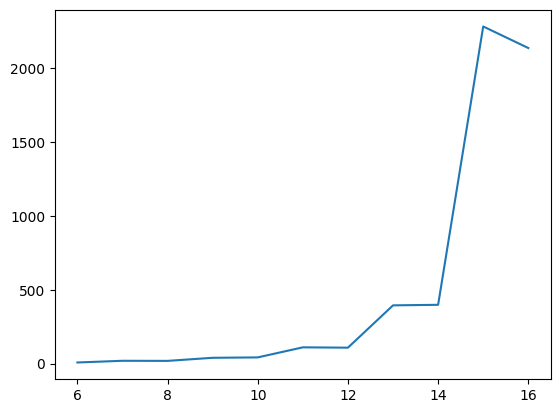

In [8]:
#vary s



pnum_mean = []
pnum_std = []
space = range(6,17)
alpha_space = np.linspace(0.9,1.7,40)
for num in space:
    env = penv.PEnv(protocols, num,threshold,decay_rate)
    depth, param, policy = optimize_p(2000,env,alpha_space)
    print(param, policy)
    pnum_mean.append(np.mean(depth))
    pnum_std.append(np.std(depth))


plt.plot(space, pnum_mean)
plt.show()
plt.plot(space, pnum_std)
plt.show()


nopnum_mean = []
nopnum_std = []
space = range(6,17)
alpha_space = np.linspace(0.9,1.7,30)
for num in space:
    env = penv.PEnv(protocols, num,threshold,decay_rate)
    depth, param, policy = optimize_nop(2000,env,alpha_space)
    print(param, policy)
    nopnum_mean.append(np.mean(depth))
    nopnum_std.append(np.std(depth))


plt.plot(space, nopnum_mean)
plt.show()
plt.plot(space, nopnum_std)
plt.show()






top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 6
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:01<00:00, 16.06it/s]


1.5344827586206895 [(0, 6), (0, 6), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 7
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:03<00:00,  9.32it/s]


1.6724137931034482 [(1, 14), (0, 7), (0, 7), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 8
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:03<00:00,  8.26it/s]


1.5068965517241377 [(1, 14), (1, 14), (0, 6), (0, 6), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 9
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


1.5068965517241377 [(1, 14), (1, 14), (1, 14), (0, 6), (0, 6), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 10
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


1.5068965517241377 [(1, 14), (1, 14), (1, 14), (1, 14), (0, 6), (0, 6), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 11
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:10<00:00,  2.75it/s]


1.5344827586206895 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 6), (0, 6), (0, 3), (0, 3), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 12
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


1.0379310344827586 [(1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 13
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


1.1758620689655173 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 8), (0, 8), (0, 5), (0, 5), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 14
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


1.0379310344827586 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 15
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [02:52<00:00,  5.76s/it]


1.0931034482758621 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]
top bin: 14
top native bin: 11
lowest native bin: 0
number of links: 16
[[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.40500000000000014]]


100%|██████████| 30/30 [08:51<00:00, 17.73s/it]

1.1206896551724137 [(1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (1, 14), (0, 7), (0, 7), (0, 4), (0, 4), (0, 2), (0, 2), (0, 0), (0, 0)]


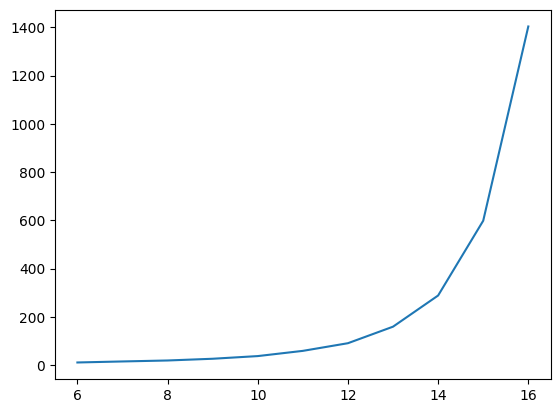

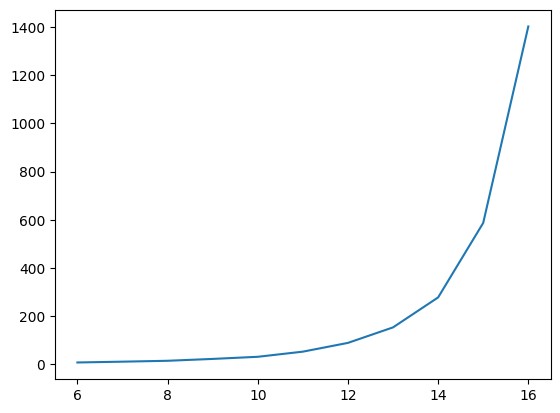

In [9]:
paltnum_mean = []
paltnum_std = []
space = range(6,17)
alpha_space = np.linspace(0.9,1.7,30)
for num in space:
    env = penv.PEnv(protocols, num,threshold,decay_rate)
    depth, param, policy = optimize_palt(2000,env,alpha_space)
    print(param, policy)
    paltnum_mean.append(np.mean(depth))
    paltnum_std.append(np.std(depth))


plt.plot(space, paltnum_mean)
plt.show()
plt.plot(space, paltnum_std)
plt.show()

In [ ]:
plam_mean = []
plam_std = []
space = np.linspace(0.1,1,20)
alpha_space = np.linspace(0.9,1.7,30)
num_qubits = 8
for lam in space:
    p1, p2 = 0.1, 0.5
    protocols = [[p1,p2],[1-lam*p1,1-lam*p2]]
    env = penv.PEnv(protocols, num_qubits,threshold,decay_rate)
    depth, param, policy = optimize_palt(2000,env,alpha_space)
    print(param, policy)
    plam_mean.append(np.mean(depth))
    plam_std.append(np.std(depth))


plt.plot(space, plam_mean)
plt.show()
plt.plot(space, plam_std)
plt.show()

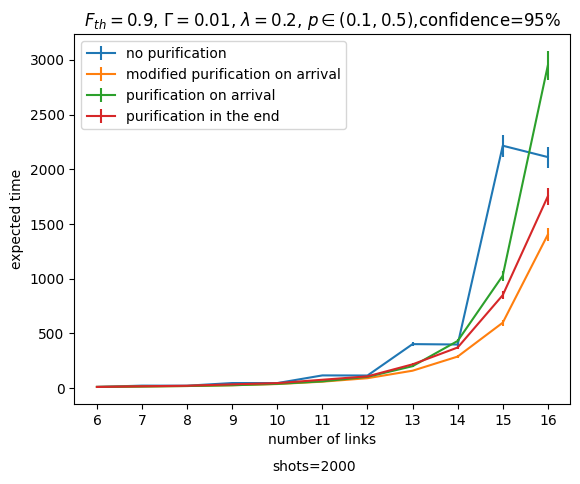

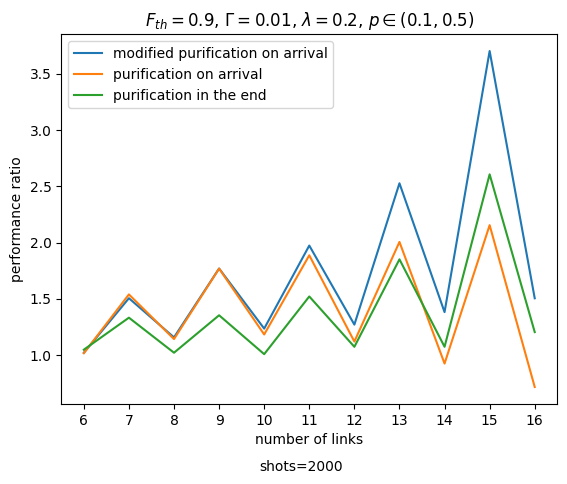

1.5045574359496934


In [14]:
plt.errorbar(space, nopnum_mean,yerr=2*np.array(nopnum_std)/np.sqrt(2000),label='no purification')
plt.errorbar(space,paltnum_mean,label='modified purification on arrival',yerr=2*np.array(paltnum_std)/np.sqrt(2000))
plt.errorbar(space,pnum_mean,label='purification on arrival',yerr=2*np.array(pnum_std)/np.sqrt(2000))
plt.errorbar(space, autonum_mean, label='purification in the end',yerr=2*np.array(autonum_std)/np.sqrt(2000))
plt.xlabel('number of links')
plt.ylabel('expected time')
plt.xticks(space)
plt.title(r'$F_{th}=0.9$, $\Gamma=0.01$, $\lambda=0.2$, $p\in(0.1,0.5)$,confidence=95%', fontsize=12)
plt.figtext(0.5, -0.03, r'shots=2000', wrap=True, horizontalalignment='center', fontsize=10)
plt.legend()
plt.show()

plt.plot(space,np.array(nopnum_mean)/np.array(paltnum_mean),label='modified purification on arrival')
plt.plot(space,np.array(nopnum_mean)/np.array(pnum_mean),label='purification on arrival')
plt.plot(space,np.array(nopnum_mean)/np.array(autonum_mean),label='purification in the end')
plt.xlabel('number of links')
plt.ylabel('performance ratio')
plt.xticks(space)
plt.title(r'$F_{th}=0.9$, $\Gamma=0.01$, $\lambda=0.2$, $p\in(0.1,0.5)$', fontsize=12)
plt.figtext(0.5, -0.03, r'shots=2000', wrap=True, horizontalalignment='center', fontsize=10)
plt.legend()
plt.show()

print(np.array(nopnum_mean)[-1]/np.array(paltnum_mean)[-1])

### Automatic purification

In [10]:
import p_env_bbp as penvbbp
import p_env_dej as penvdej
p1, p2 = 0.1, 0.5
lam = 0.2
protocols = [[p1,p2],[1-lam*p1,1-lam*p2]]
num_qubits = 12
threshold = 0.9
decay_rate = 0.01
# env_bbp = penvbbp.PEnvBBP(protocols, num_qubits,threshold,decay_rate)
env_dej = penvdej.PEnvDEJ(protocols, num_qubits,threshold,decay_rate)

top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


In [11]:
def policy_maker_auto(env_auto, alpha = 1):
    ahead = [0]
    actions = env_auto.actions
    policy = []
    count = 0
    
    for i in range(env_auto.num_qubits):
        action = 0
        #non purification
        lb = env_auto.bin_size_min if env_auto.bin_size_min>=0 else 0
        if i==0:
            action = lb
        else:
            n = np.floor(ahead[i-1]).astype(int)
            if n<lb:
                n = lb
            elif n>env_auto.bin_size:
                n = env_auto.bin_size
            action = n
        policy.append(action)
        prev_ahead = ahead[i-1]

        ahead.append(prev_ahead + alpha/actions[policy[i]])
    ahead = ahead[0:len(ahead)-1:1]
    return policy[::-1], ahead[::-1]

policy_maker_auto(env_dej)

([11, 11, 10, 10, 6, 6, 4, 4, 1, 1, 0, 0],
 [24.71759454525089,
  16.527336220907756,
  16.527336220907756,
  10.206004586418825,
  10.206004586418825,
  6.861872199390892,
  6.861872199390892,
  4.139783693696586,
  4.139783693696586,
  1.9999999999999996,
  1.9999999999999996,
  0])

top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:03<00:00,  9.30it/s]


1.5068965517241377 [6, 6, 3, 3, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:05<00:00,  5.64it/s]


1.3689655172413793 [9, 5, 5, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


1.4241379310344828 [10, 10, 6, 6, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


1.203448275862069 [11, 8, 8, 5, 5, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


1.1758620689655173 [11, 11, 8, 8, 5, 5, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


1.0103448275862068 [11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [00:41<00:00,  1.39s/it]


1.0103448275862068 [11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [01:24<00:00,  2.82s/it]


1.0103448275862068 [11, 11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [02:30<00:00,  5.01s/it]


1.0103448275862068 [11, 11, 11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [06:31<00:00, 13.05s/it]


1.0103448275862068 [11, 11, 11, 11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]
top bin: 14
top native bin: 11
lowest native bin: 0
[0.5000000000000001, 0.4673369569764543, 0.4343456449130436, 0.40102276465107023, 0.36736498387473854, 0.3333689367779215, 0.29903122372758123, 0.264348410923796, 0.22931703005638415, 0.19393357795806596, 0.1581945162541449, 0.12209627100866821, -1, -1, -1]


100%|██████████| 30/30 [14:30<00:00, 29.01s/it]

1.0103448275862068 [11, 11, 11, 11, 11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0]


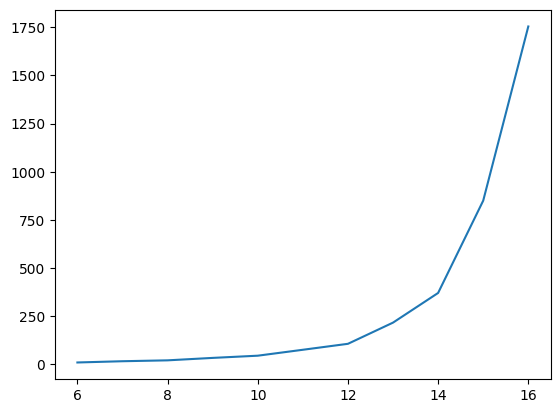

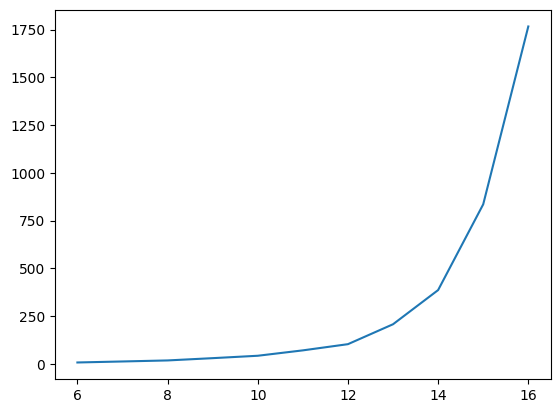

In [12]:
def optimize_auto(shots, env, alpha_space):
    param = -1
    best_depth = sys.maxsize
    depth_data = []
    policy_data = []
    for alpha in tqdm(alpha_space):
        policy, t_ahead = policy_maker_auto(env, alpha)
        depth_heuristic = batch_heuristic(shots,env,policy,False) 

        depth = np.mean(depth_heuristic)
        if  best_depth>depth:
            best_depth = depth
            depth_data = depth_heuristic
            policy_data = policy
            param = alpha
    return depth_data, param, policy_data

autonum_mean = []
autonum_std = []
space = range(6,17)
alpha_space = np.linspace(0.9,1.7,30)
for num in space:
    env = penvdej.PEnvDEJ(protocols, num,threshold,decay_rate)
    depth, param, policy = optimize_auto(2000,env,alpha_space)
    print(param,policy)
    autonum_mean.append(np.mean(depth))
    autonum_std.append(np.std(depth))


plt.plot(space, autonum_mean)
plt.show()
plt.plot(space, autonum_std)
plt.show()

In [10]:
# h_mean_bbp = []
# h_std_bbp = []
# space = np.linspace(1,1.7,100)
# for alpha in space:
#     policy, t_ahead = policy_maker_auto(env_bbp, alpha)
#     print(policy,alpha)
#     depth_heuristic = batch_heuristic(2000,env_bbp,policy,False)
#     h_mean_bbp.append(np.mean(depth_heuristic))
#     h_std_bbp.append(np.std(depth_heuristic))

# print(np.amin(h_mean_bbp))
# plt.plot(space, h_mean_bbp)
# plt.show()
# plt.plot(space, h_std_bbp)
# plt.show()

[8, 8, 8, 8, 6, 6, 4, 4, 1, 1, 0, 0] 1.0


KeyboardInterrupt: 

In [118]:
h_mean_dej = []
h_std_dej = []
space = np.linspace(1,1.7,100)
for alpha in space:
    policy, t_ahead = policy_maker_auto(env_dej, alpha)
    print(policy,alpha)
    depth_heuristic = batch_heuristic(2000,env_dej,policy,False)
    h_mean_dej.append(np.mean(depth_heuristic))
    h_std_dej.append(np.std(depth_heuristic))

print(np.amin(h_mean_dej))
plt.plot(space, h_mean_dej)
plt.show()
plt.plot(space, h_std_dej)
plt.show()

[11, 11, 10, 10, 6, 6, 4, 4, 1, 1, 0, 0] 1.0
[11, 11, 10, 10, 7, 7, 4, 4, 2, 2, 0, 0] 1.007070707070707


KeyboardInterrupt: 

### memory

In [80]:
import p_env_mem as penvm 


p1, p2 = 0.2, 0.5
lam = 0.1
protocols = [[p1,p2],[1-lam*p1,1-lam*p2]]
num_qubits = 20
threshold = 0.9
decay_rate = 0.01
env_mem = penvm.PEnvMem(protocols, num_qubits,threshold,decay_rate)

top bin: 14
top native bin: 11
lowest native bin: 7
[-1, -1, -1, -1, -1, -1, -1, 0.5286968218475914, 0.4586340601127677, 0.3878671559161314, 0.31638903250828937, 0.2441925420173361, -1, -1, -1]


In [93]:
def batch_heuristic(shots, env, policy, progress = True, t_ahead=None):
    depth_heuristic = []
    if progress == True:
        bar = tqdm(range(shots))
    else:
        bar = range(shots)
    for i in bar:
        if t_ahead == None:
            depth = env.run(policy)
        else:
            depth = env.run(policy, t_ahead)
        depth_heuristic.append(depth)
    return depth_heuristic

policy, t_ahead = policy_maker_auto(env_mem)
test = batch_heuristic(1,env_mem,policy,t_ahead=t_ahead)
print('can run one batch')
depth_heuristic = batch_heuristic(2000,env_mem,policy,t_ahead=t_ahead)
print(np.mean(depth_heuristic))
print(np.std(depth_heuristic))

100%|██████████| 1/1 [00:00<00:00, 47.19it/s]


can run one batch


100%|██████████| 2000/2000 [00:45<00:00, 44.33it/s]

1004.0485
1012.6375497421326


In [47]:
h_mean_mem = []
h_std_mem = []
space = np.linspace(1,1.6,50)
for alpha in space:
    policy, t_ahead = policy_maker_auto(env_mem, alpha)
    print(policy,alpha)
    depth_heuristic = batch_heuristic(2000,env_mem,policy,False,t_ahead)
    h_mean_mem.append(np.mean(depth_heuristic))
    h_std_mem.append(np.std(depth_heuristic))

print(np.amin(h_mean_auto))
plt.plot(space, h_mean_auto)
plt.show()
plt.plot(space, h_std_auto)
plt.show()

[11, 11, 11, 11, 11, 11, 11, 11, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 1.0


KeyboardInterrupt: 

### Graphics

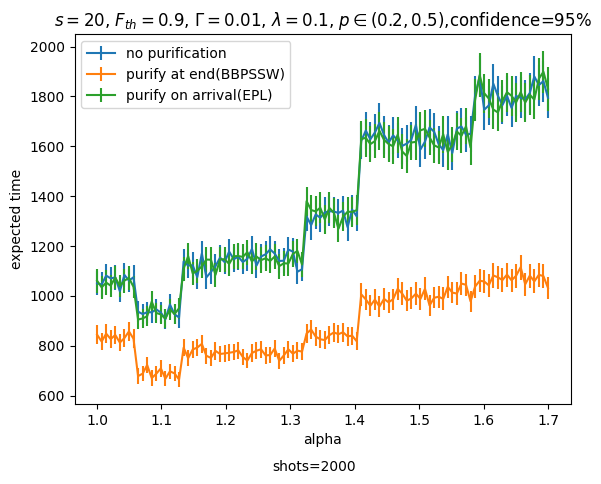

In [120]:

plt.errorbar(space, h_mean_cmp,yerr=2*np.array(h_std_cmp)/np.sqrt(2000),label='no purification')
plt.errorbar(space, h_mean_auto,yerr=2*np.array(h_std_auto)/np.sqrt(2000),label='purify at end(BBPSSW)')
plt.errorbar(space, h_mean,yerr=2*np.array(h_std)/np.sqrt(2000), label='purify on arrival(EPL)')
plt.legend(bbox_to_anchor=(0.75, 1.15), ncol=2)
plt.xlabel('alpha')
plt.ylabel('expected time')
plt.legend()
plt.title(r'$s=20$, $F_{th}=0.9$, $\Gamma=0.01$, $\lambda=0.1$, $p\in(0.2,0.5)$,confidence=95%', fontsize=12)
plt.figtext(0.5, -0.03, r'shots=2000', wrap=True, horizontalalignment='center', fontsize=10)
plt.show()
# plt.plot(space, h_std,label='heuristic')
# plt.plot(space, np.full(len(space),fill_value=std_depth_random),label='random')
# plt.plot(space, np.full(len(space),fill_value=std_depth_fixed),label='fixed')
# plt.legend(bbox_to_anchor=(0.75, 1.15), ncol=2)
# plt.xlabel('alpha')
# plt.ylabel('standard deviation')
# plt.show()
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=[0.25,1])
# # fig.subplots_adjust(hspace=0.05)  # adjust space between axes
# fig.subplots_adjust(hspace=0.05)  # adjust space between axes
# fig.suptitle(r'$s=4$, $F_{th}=0.5$, $\Gamma=0.17$, $\lambda=1$, confidence=95%', fontsize=12)
# # plot the same data on both axes
# errorh = 2*np.array(h_std)/np.sqrt(2000)
# ax2.errorbar(space, h_mean, yerr=errorh, label='linear')
# ax2.plot(space, np.full(len(space),fill_value=m_depth_fixed), label='fixed')
# ax1.plot(space, np.full(len(space),fill_value=m_depth_random),label='random',c='green')




# zoom-in / limit the view to different portions of the data
# ax2.set_ylim(60,180)  
# ax1.set_ylim(450,480)
# ax1.spines.bottom.set_visible(False)
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

# d = 0.5  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# ax1.legend()
# ax2.legend()

# plt.xlabel('alpha')
# plt.ylabel('expected time')
# txt=r'fixed error=7.87;random error=19.87;shots=2000'
# plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=10)
# plt.show()